# Functionalized Backtester

In [27]:
import pandas as pd 
import numpy as np
from pairs import selection 

from copulas.copulae import GumbelCopula
from analysis.performance import perf_summ 

from sklearn.linear_model import RANSACRegressor, HuberRegressor
from backtest.signal_ import SignalGeneration, generate_signals

import matplotlib.pyplot as plt

from backtest.backtester import backtest
from backtest.positions import calc_rolling_betas

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

Importing Price Data

In [83]:
WINDOW_SIZE = 252
MOD_REGRESSION = 3 
TRANSACTION_COST = 0.0002

In [84]:
import v2.backtest.signal_ as sig
import v2.backtest.backtester as bt

prices = pd.read_csv('raw_prices_sample.csv', index_col=0, parse_dates=[0])

start = '2016-01-01'
end = '2018-01-01'
trading_end = '2019-01-01'

pairs = [('SPY', 'IVV'), ('IVE', 'VOOV')]

signal_object = sig.SignalGeneration(prices, pairs, start, end, trading_end, copula_type = 'mixed', n= 10)
sig1 = signal_object.calc_signals()

In [85]:
# We can look at the copulas too
cop_1 = signal_object.copulae[pairs[0]]
print(f'Pair 1: {pairs[0]}')
print(f'Copula 1: {cop_1.copula1.__class__.__name__}')
print(f'Copula 2: {cop_1.copula2.__class__.__name__}')
print(f'Alpha (mixing parameter): {cop_1.alpha}')
print('~'*50)
cop_2 = signal_object.copulae[pairs[1]]
print(f'Pair 2: {pairs[1]}')
print(f'Copula 1: {cop_2.copula1.__class__.__name__}')
print(f'Copula 2: {cop_2.copula2.__class__.__name__}')
print(f'Alpha (mixing parameter): {cop_2.alpha}')

Pair 1: ('SPY', 'IVV')
Copula 1: GumbelCopula
Copula 2: GaussianCopula
Alpha (mixing parameter): 5.9608609865491405e-06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Pair 2: ('IVE', 'VOOV')
Copula 1: GumbelCopula
Copula 2: GaussianCopula
Alpha (mixing parameter): 0.5767879985015588


In [89]:
# Setup the two input DataFrames
spy_ivv = prices[['SPY', 'IVV']].loc[end:trading_end]
ive_voo = prices[['IVE', 'VOOV']].loc[end:trading_end]

# Setup the buy/sell signals
spy_ivv['Signal'] = signal_object.generate_signals(sig1 = sig1[pairs[0]]).values
ive_voo['Signal'] = signal_object.generate_signals(sig1 = sig1[pairs[1]]).values

# Setup the betas -- assume that we can match notionals for simplicity.
spy_ivv['Betas'] = np.round(prices['SPY'].loc[end:trading_end] / prices['IVV'].loc[end:trading_end], 2)
ive_voo['Betas'] = np.round(prices['IVE'].loc[end:trading_end] / prices['VOOV'].loc[end:trading_end], 2)

bt.backtest(spy_ivv, contract_size=100, TRANSACTION_COST=0.000)

,SPY,IVV,Signal,Betas,Transaction Cost,Daily PnL,Pos 1,Pos 2,Position Value,Total PnL,Total Transaction
date,,,,,,,,,,,
2018-01-02,246.612280,249.775919,3,0.99,0,0.000000,300.0,-297.0,-199.763869,0.000000,0
2018-01-03,248.172130,251.223762,-3,0.99,0,37.945712,0.0,0.0,0.000000,37.945712,0
2018-01-04,249.218147,252.311949,0,0.99,0,0.000000,0.0,0.0,0.000000,37.945712,0
2018-01-05,250.878929,253.907343,-2,0.99,0,0.000000,-200.0,198.0,97.868122,37.945712,0
2018-01-08,251.337708,254.469881,2,0.99,0,19.626565,0.0,0.0,0.000000,57.572277,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,219.133005,221.958653,3,0.99,0,36.249437,0.0,0.0,0.000000,2187.595965,0
2018-12-26,230.204673,232.845523,-3,0.99,0,0.000000,-300.0,297.0,93.718336,2187.595965,0
2018-12-27,231.972026,235.092468,3,0.99,0,137.136840,0.0,0.0,0.000000,2324.732806,0


Compare copula and linear method for a pair

In [5]:
def calc_quantiles(spread):
    # Comparison for linear model.
    up_1 = spread.quantile(.95).item()
    up_2 = spread.quantile(.9).item()
    up_3 = spread.quantile(.85).item()
    lo_1 = spread.quantile(0.05).item()
    lo_2 = spread.quantile(0.10).item()
    lo_3 = spread.quantile(0.15).item()
    exit_up = spread.quantile(0.80).item()
    exit_lo = spread.quantile(0.2).item()
    return [up_1,up_2,up_3,lo_1,lo_2,lo_3,exit_up,exit_lo]

In [7]:
def simulate(pair, prices, signal_probabilities, FIT_START, FIT_END, TEST_END, mod=MOD_REGRESSION, contracts=100, TRANSACTION_COST=0.0):
    # Copula Signals
    copula_signals = generate_signals(signal_probabilities[pair])
    price_list = prices[[pair[0],pair[1]]]
    
    # Get betas
    betas = calc_rolling_betas(prices[pair[0]],prices[pair[1]],prices['SPY'],mod=mod, WINDOW_SIZE=WINDOW_SIZE)
    copula_prices = pd.concat([price_list,copula_signals,betas],axis=1)
    copula_prices = copula_prices.dropna()

    # Linear model
    rets = prices[[pair[0],pair[1]]].pct_change().dropna()
    spread = (rets[pair[0]] - rets[pair[1]]).to_frame('Spread')
    train_spread = spread.loc[FIT_START:FIT_END]
    test_spread = spread.loc[FIT_END:TEST_END]
    q = calc_quantiles(train_spread)
    linear_signals = generate_signals(test_spread,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7])
    linear_prices = pd.concat([price_list,linear_signals,betas],axis=1)
    linear_prices = linear_prices.dropna()

    # Backtest
    copula_backtest = backtest(copula_prices,contract_size=contracts, TRANSACTION_COST=TRANSACTION_COST)
    linear_backtest = backtest(linear_prices,contract_size=contracts, TRANSACTION_COST=TRANSACTION_COST)

    copula_tot_pnl = copula_backtest['Total PnL']
    linear_tot_pnl = linear_backtest['Total PnL']

    tot_pnl = pd.concat([copula_tot_pnl,linear_tot_pnl],axis=1)
    tot_pnl.columns = ['Copula','Linear']

    return tot_pnl, copula_backtest, linear_backtest

In [8]:
def analyze(pnls, prices, capital=10000):
    portfolio = pnls + capital 
    rets = portfolio.pct_change().dropna()

    metrics = perf_summ(rets,adj=252,mkt=prices.pct_change().dropna().loc[rets.index,'SPY']).T
    metrics = metrics.loc[['Annualized Return',
                        'Annualized Volatility',
                        'Annualized Sharpe Ratio',
                        'Annualized Sortino Ratio',
                        'Market Beta',
                        'Market Alpha',
                        'Max Drawdown']]
    
    return metrics 

In [9]:
def main(y, n, pair_list = None):
    global FIT_START, FIT_END, TEST_START, TEST_END, WINDOW_SIZE, MOD_REGRESSION
    global prices, signal_probabilities
    
    FIT_START = str(y)
    FIT_END = str(y+2)

    TEST_START = FIT_END 
    TEST_END = str(y+3)

    WINDOW_SIZE = 252 

    
    idx_start = raw_prices.index.get_loc(raw_prices.loc[FIT_START:].index[0])
    prices = raw_prices.iloc[idx_start-WINDOW_SIZE:]
    prices = prices.dropna(axis=1)
    prices = prices.loc[:TEST_END]

    training_data = prices.loc[FIT_START:FIT_END]
    test_data = prices.loc[TEST_START:TEST_END]

    if not pair_list:
        pairs = selection.PairSelection(prices.loc[FIT_START:FIT_END])
        pairs.create_clusters()
        pairs.test_coint()
        pair_list = pairs.get_pairs(number_of_pairs=5)

    sig_gen = SignalGeneration(prices,pairs=pair_list,train_start=FIT_START,oos_start=TEST_START,n=n)
    signal_probabilities = sig_gen.calc_signals()
    signal_probabilities.index = prices[TEST_START:TEST_END].index


    pair_idx = pd.MultiIndex.from_product([pair_list, ['Copula','Linear']])
    res = pd.DataFrame(columns=pair_idx,index=['Annualized Return',
                            'Annualized Volatility',
                            'Annualized Sharpe Ratio',
                            'Annualized Sortino Ratio',
                            'Market Beta',
                            'Market Alpha',
                            'Max Drawdown'])
        
    copula_pnls = pd.DataFrame(columns=pair_list)
    linear_pnls = pd.DataFrame(columns=pair_list)
    for pair in pair_list:
        pnls, _, _ = simulate(pair, prices, signal_probabilities, FIT_START=FIT_START, FIT_END=FIT_END, TEST_END=TEST_END, contracts=20, TRANSACTION_COST=TRANSACTION_COST)
        copula_pnls[pair] = pnls['Copula']
        linear_pnls[pair] = pnls['Linear']

    copula_pnls['Total PnL'] = copula_pnls.sum(axis=1)
    linear_pnls['Total PnL'] = linear_pnls.sum(axis=1)

    port_pnl = pd.concat([copula_pnls['Total PnL'],linear_pnls['Total PnL']],axis=1)
    port_pnl.columns = ['Copula Weighted','Linear Weighted']

    performance = analyze(port_pnl, prices)
    return performance.iloc[:,0], performance.iloc[:,1]

In [11]:
from tqdm import tqdm

cop_res10 = []
cop_res30 = []
linear_res = []
for y in tqdm(range(1998, 2021), desc = 'Year'):
    i, j = main(y, n = 10)
    k, _ = main(y, n = 30)
    cop_res10.append(i.rename(y+2, inplace = True))
    cop_res30.append(k.rename(y+2, inplace = True))
    linear_res.append(j.rename(y+2, inplace = True))
    
    c10 = pd.concat(cop_res10, axis=1).T
    c30 = pd.concat(cop_res30, axis=1).T
    l_res = pd.concat(linear_res, axis=1).T
    
    # l_res.style.format(precision=3, na_rep='-', thousands=',').to_latex('../Writeup/linear_res_trans.tex')
    # c30.style.format(precision=3, na_rep='-', thousands=',').to_latex('../Writeup/copula_n30_trans.tex')
    # c10.style.format(precision=3, na_rep='-', thousands=',').to_latex('../Writeup/copula_n10_trans.tex')

    # l_res.to_csv('./trade_result/linear_res_trans.csv')
    # c10.to_csv('./trade_result/cop_res_n10_trans.csv')
    # c30.to_csv('./trade_result/cop_res_n30_trans.csv')

Year: 100%|██████████| 23/23 [1:02:19<00:00, 162.60s/it]


In [12]:
c10 = pd.concat(cop_res10, axis=1).T
c30 = pd.concat(cop_res30, axis=1).T
l_res = pd.concat(linear_res, axis=1).T

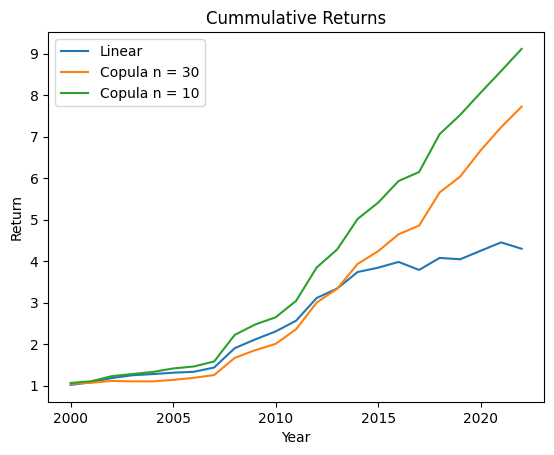

In [15]:
(l_res.iloc[:, 0] +1).cumprod().plot(title='Cummulative Returns', xlabel = 'Year', ylabel = 'Return')
(c30.iloc[:, 0] +1).cumprod().plot()
(c10.iloc[:, 0] +1).cumprod().plot()
plt.legend(['Linear', 'Copula n = 30', "Copula n = 10"])
plt.savefig('../Writeup/cummulative_ret.svg', format='svg')

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Market Beta,Market Alpha,Max Drawdown
2000,0.064464,0.026168,2.463424,4.405534,-0.017151,0.000251,-0.0078
2001,0.038135,0.027413,1.391129,1.932789,0.035027,0.000165,-0.026635
2002,0.110336,0.045119,2.445445,3.006977,0.038935,0.000474,-0.024111
2003,0.042064,0.016317,2.577983,3.969087,-0.019922,0.000184,-0.00888
2004,0.039153,0.043996,0.889912,1.077926,-0.006277,0.000158,-0.032319
2005,0.063669,0.035893,1.773881,2.164965,-0.011338,0.000254,-0.027054
2006,0.033827,0.020302,1.666184,2.392993,-0.014013,0.000141,-0.009738
2007,0.082904,0.039079,2.12144,2.944449,-0.012471,0.000331,-0.029909
2008,0.404008,0.082105,4.920641,9.187149,-0.041342,0.001539,-0.018119
2009,0.113156,0.025971,4.357112,11.14667,-0.007051,0.000455,-0.005818


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Market Beta,Market Alpha,Max Drawdown
2000,0.017038,0.02547,0.668957,1.068991,-0.007614,0.000065,-0.013976
2001,0.065028,0.020878,3.11471,5.33961,0.010421,0.000262,-0.014793
2002,0.091673,0.035937,2.550974,4.013836,0.005773,0.000369,-0.010758
2003,0.056907,0.014379,3.957538,8.682611,0.015955,0.000212,-0.002983
2004,0.022703,0.03745,0.606225,0.681381,-0.029914,0.000101,-0.045479
2005,0.026365,0.030739,0.857697,1.034519,-0.008626,0.000106,-0.018445
2006,0.015712,0.015555,1.010062,1.819869,-0.016971,0.00007,-0.011772
2007,0.077996,0.025267,3.086844,8.417945,-0.00307,0.00031,-0.009453
2008,0.323632,0.106424,3.040962,3.14361,0.070762,0.001393,-0.070346
2009,0.1114,0.024413,4.563217,12.54128,-0.008154,0.000449,-0.006109


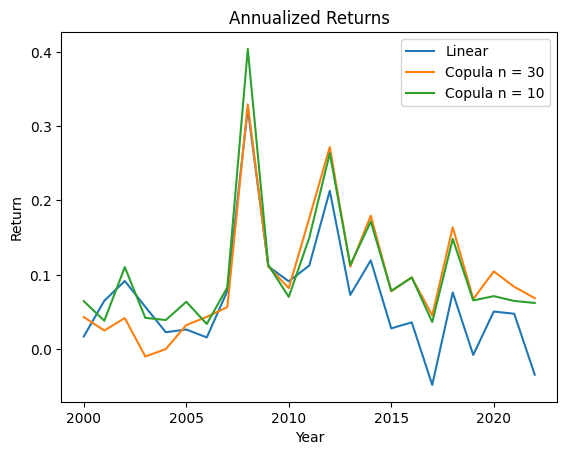

In [19]:
l_res.iloc[:, 0].plot(title='Annualized Returns', xlabel = 'Year', ylabel = 'Return')
c30.iloc[:, 0].plot()
c10.iloc[:, 0].plot()
plt.legend(['Linear', 'Copula n = 30', "Copula n = 10"])
display(c10)
display(l_res)

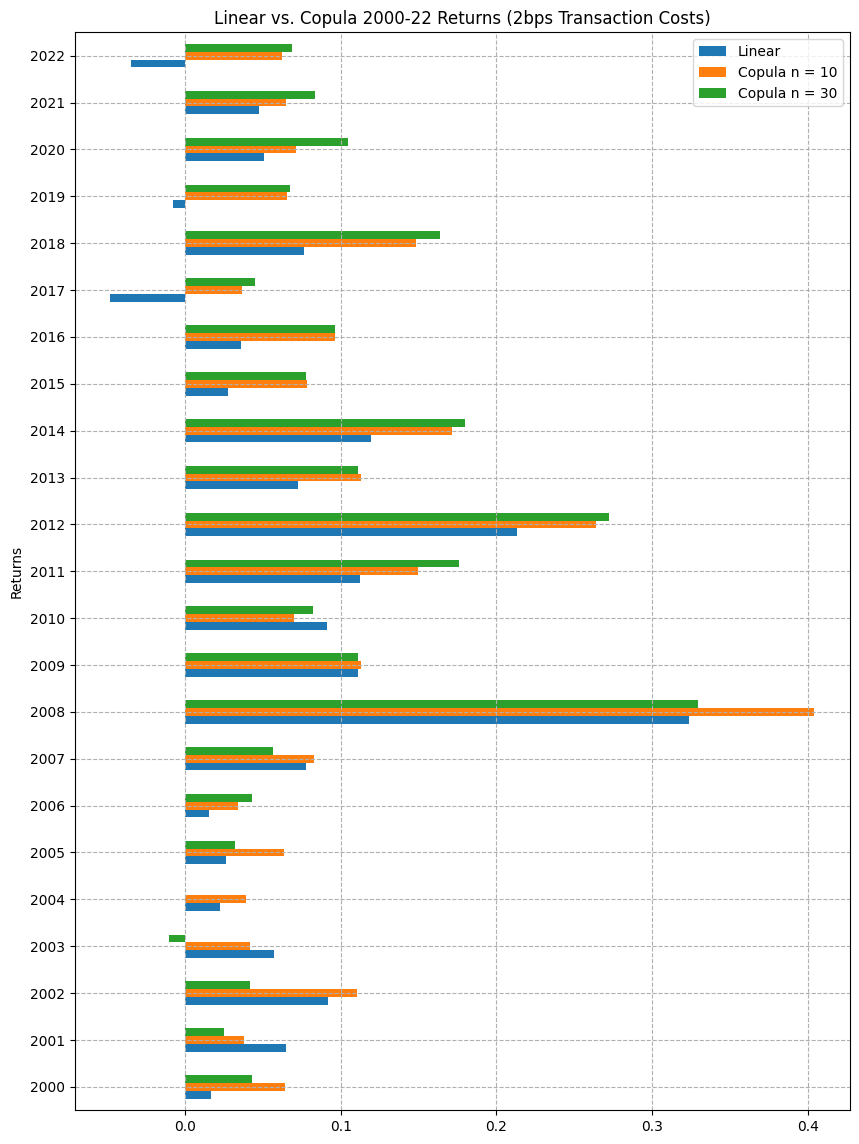

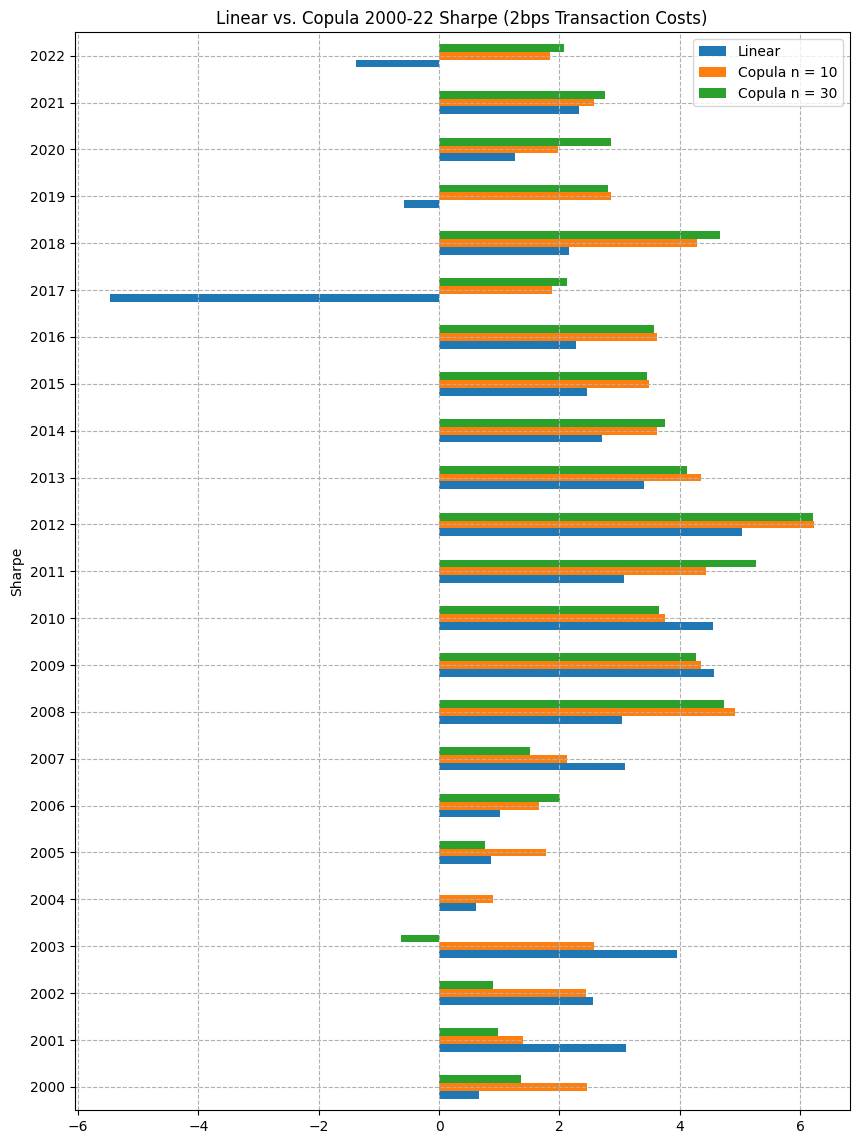

In [33]:
rets = pd.DataFrame({'Linear': l_res.iloc[:, 0], 'Copula n = 10': c10.iloc[:, 0], 'Copula n = 30': c30.iloc[:, 0]})

fig, ax = plt.subplots(figsize=(10,14))
rets.plot(kind='barh', ax=ax)
ax.set_title(f'Linear vs. Copula 2000-22 Returns (2bps Transaction Costs)')
ax.grid(linestyle='--')
ax.set_ylabel('Returns')

rets = pd.DataFrame({'Linear': l_res.iloc[:, 2], 'Copula n = 10': c10.iloc[:, 2], 'Copula n = 30': c30.iloc[:, 2]})

fig, ax = plt.subplots(figsize=(10,14))
rets.plot(kind='barh', ax=ax)
ax.set_title(f'Linear vs. Copula 2000-22 Sharpe (2bps Transaction Costs)')
ax.grid(linestyle='--')
ax.set_ylabel('Sharpe')
plt.show()

## Sample Demo

In [34]:
# Given a DataFrame indexed by time, with asset prices as columns,
# split into training/testing sets.
FIT_START = '2020-01-01'
FIT_END = '2021-12-31'
TEST_START = '2022-01-01'
TEST_END = '2022-12-31'
TRANSACTION_COST = 0.0002

# Select the pairs from the data.
from pairs.selection import PairSelection

pairs = PairSelection(raw_prices.loc[FIT_START:FIT_END])

# Create the clusters via OPTICS
pairs.create_clusters()

# Test cointegration; get pairs that are most cointegrated in-sample.
pairs.test_coint()
pair_list = pairs.get_pairs(number_of_pairs=5)
display(pair_list)

[('IWO', 'VTWG'),
 ('IVV', 'SPLG'),
 ('VTHR', 'VTI'),
 ('IVE', 'SPYV'),
 ('SPY', 'VOO')]

In [36]:
# Next, we fit the copula, using n=30 as a smoothing parameter,
# this automatically calculates the mixed copula parameters.
sig_gen = SignalGeneration(prices,pairs=pair_list,train_start=FIT_START,oos_start=TEST_START,n=30)

# Turn the probabilities into signals for OOS data.
signal_probabilities = sig_gen.calc_signals()
signal_probabilities.index = prices[TEST_START:TEST_END].index


# Results DataFrame.
res = pd.DataFrame(columns=['Copula'],index=['Annualized Return',
                        'Annualized Volatility',
                        'Annualized Sharpe Ratio',
                        'Annualized Sortino Ratio',
                        'Market Beta',
                        'Market Alpha',
                        'Max Drawdown'])
        
copula_pnls = pd.DataFrame(columns=pair_list)

for pair in pair_list:
    # Simulate the strategy.    
    pnls, _, _ = simulate(pair, prices, signal_probabilities, FIT_START=FIT_START, FIT_END=FIT_END, TEST_END=TEST_END, contracts=20, TRANSACTION_COST=TRANSACTION_COST)
    copula_pnls[pair] = pnls['Copula']

    copula_pnls['Total PnL'] = copula_pnls.sum(axis=1)

    port_pnl = pd.DataFrame(copula_pnls['Total PnL'])
    port_pnl.columns = ['Copula Weighted']

    # Analyze the performance.
    performance = analyze(port_pnl, prices)

In [37]:
performance

,Copula Weighted
Annualized Return,0.030489
Annualized Volatility,0.225723
Annualized Sharpe Ratio,0.135072
Annualized Sortino Ratio,0.073293
Market Beta,-0.030321
Market Alpha,0.000097
Max Drawdown,-0.198934
